The idea of this notebook is to study how linear certain layers are. Inspired by ["Your transformer is secretly linear"](https://arxiv.org/pdf/2405.12250)

In [3]:
from pathlib import Path
from typing import Callable, Optional
from dataclasses import dataclass

from tensor_utils import TensorStorage, ConsecutiveOutputsDataset

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

In [4]:
def normalize(x): 
    X = x - x.mean(dim=0, keepdim=True)
    return X / X.norm()

def get_A_est(X, Y):
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    A_estimation = Vh.T * (1 / S)[None, ...] @ U.T @ Y # Y=XA
    return A_estimation

def get_est_svd(X, Y):
    """
    X -- torch tensor with shape [n_samples, dim]
    Y -- torch tensor with shape [n_samples, dim]

    Approximates Y matrix with linear transformation Y = XA
    """
    A_estimation = get_A_est(X, Y) 
    Y_est =  X @ A_estimation
    return Y_est

def compute_linearity_score(x, y):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad(): 
        X, Y = normalize(x), normalize(y)
        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

In [16]:
data_path = Path('./data_opt125m')
num_blocks = len(list(data_path.iterdir()))
data = ConsecutiveOutputsDataset(data_path, 0) 
hidden_size = data[0][0].numel()
print(num_blocks, hidden_size)

13 768


In [17]:
block_embeddings = [[] for _ in range(data.num_layers)]
for x, v1, v2, blocks in data:
    block = blocks[0]
    block_embeddings[block].append(x.cpu())
    if block == data.num_layers - 2:
        block_embeddings[block + 1].append(v2.cpu())

In [18]:
block_embeddings = [torch.cat(x).reshape(-1, hidden_size).cuda() for x in block_embeddings]

In [19]:
block_embeddings[0].shape

torch.Size([4695, 768])

In [20]:
compute_linearity_score(torch.randn_like(block_embeddings[0]), torch.randn_like(block_embeddings[0]))

0.16349244117736816

In [21]:
k = 1
for idx in range(data.num_layers - k):
    print(idx, compute_linearity_score(block_embeddings[idx], block_embeddings[idx + k]))

0 0.925683856010437
1 0.9518418312072754
2 0.9581395387649536
3 0.9647754430770874
4 0.9484754204750061
5 0.9381443858146667
6 0.9413374066352844
7 0.9413102865219116
8 0.9302809238433838
9 0.9235631823539734
10 0.9342614412307739
11 1.0


In [22]:
def get_linearity_dist(block1, block2):
    n_samples = block1.size(0)
    assert n_samples == block2.size(0)
    X, Y = normalize(block1), normalize(block2)
    A_est = get_A_est(X, Y)
    linearities = torch.zeros(n_samples)
    for idx, (x, y) in enumerate(zip(X, Y)): 
        err = (A_est @ x - y).square().sum() 
        linearities[idx] = 1 - err 

    return linearities

In [23]:
get_linearity_dist(block_embeddings[0], block_embeddings[-1])

tensor([0.9990, 0.9992, 0.9992,  ..., 0.9994, 0.9986, 0.9991])

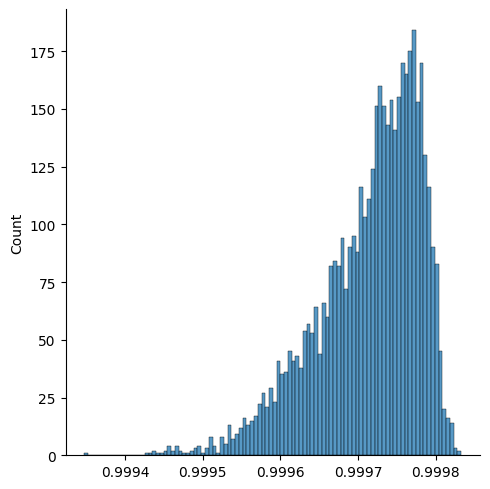

In [24]:
import seaborn as sns

sns.displot(get_linearity_dist(block_embeddings[2], block_embeddings[7]), bins=100)

In [25]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, embed_dim: int, hidden_size: int):
        super(SimpleAutoEncoder, self).__init__()

        self.fc1 = nn.Linear(embed_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embed_dim, hidden_size)
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [26]:
N = len(data)
train_len = int(N * 0.7)
train_data, test_data = random_split(data, lengths=[train_len, N - train_len])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
tgt_block = 3

In [27]:
criterion = nn.MSELoss()
# model = SimpleAutoEncoder(768, 768).to('cuda')
model = nn.Linear(768, 768).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for epoch in range(10):
    epoch_loss = 0
    model.train()
    for x, v1, v2, blocks in train_loader:
        x_blocks = blocks[:, 0]
        indices = x_blocks == tgt_block 
        if indices.sum() == 0:
            continue
        
        optimizer.zero_grad()
        outputs = model(x[indices])
        loss = criterion(outputs , v1[indices])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    test_loss = 0
    model.eval()
    for x, v1, v2, blocks in test_loader:
        x_blocks = blocks[:, 0]
        indices = x_blocks == tgt_block
        if indices.sum() == 0:
            continue
    
        outputs = model(x[indices])
        loss = criterion(outputs, v1[indices])
        test_loss += loss.item()

    print(f'{epoch=}, Train loss: {epoch_loss / len(train_data):.4e}, Test loss {test_loss / len(test_data):.4e}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
for idx in range(len(block_embeddings)):
    print(idx, block_embeddings[idx].norm(dim=-1).mean()) 

0 tensor(1.6440, device='cuda:0')
1 tensor(2.5635, device='cuda:0')
2 tensor(3.1261, device='cuda:0')
3 tensor(4.0580, device='cuda:0')
4 tensor(4.3789, device='cuda:0')
5 tensor(4.8121, device='cuda:0')
6 tensor(5.1682, device='cuda:0')
7 tensor(5.6405, device='cuda:0')
8 tensor(6.2163, device='cuda:0')
9 tensor(7.1597, device='cuda:0')
10 tensor(8.5492, device='cuda:0')
11 tensor(10.3722, device='cuda:0')
12 tensor(9.9927, device='cuda:0')


In [ ]:
F.cosine_similarity(block_embeddings[0][0], block_embeddings[1][0], dim=0)

tensor(0.0503, device='cuda:0')

In [ ]:
for idx in range(len(block_embeddings) - 1):
    print(idx, F.cosine_similarity(block_embeddings[idx], block_embeddings[idx + 1], dim=-1).mean())

0 tensor(0.7336, device='cuda:0')
1 tensor(0.9431, device='cuda:0')
2 tensor(0.9613, device='cuda:0')
3 tensor(0.9715, device='cuda:0')
4 tensor(0.9599, device='cuda:0')
5 tensor(0.9502, device='cuda:0')
6 tensor(0.9487, device='cuda:0')
7 tensor(0.9480, device='cuda:0')
8 tensor(0.9332, device='cuda:0')
9 tensor(0.9221, device='cuda:0')
10 tensor(0.9286, device='cuda:0')
11 tensor(0.9055, device='cuda:0')
